<div style="background-color:#035FCA; color:#19180F; font-size:40px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> MarianMT </div>
<div style="background-color:#568FD1; color:#19180F; font-size:30px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> Architectural Overview.
 </div>
<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
It is an architecture designed specifically for machine translation tasks.<br>
The building blocks of the architecture are elaborated below.<br>

1. Encoder - The encoder block in MarianMT is responsible for processing the input source language and capturing its contextual information. It consists of multiple layers of self attn and feed fwd networks. The self attn mechanism allows the model to weigh the importance of diff words in the source sentence while capturing dependencies b/w them.<br>

2. Decoder - The decoder block in it generates the translated target lang based on the encoded source language representation. It also consists of multiple layers of self attn and feed fwd networks. In addition to the self attn mechanism, the decoder also employs another attn mechanism called encoder-decoder attn. This allows the models to focus on relevant parts of the source sentence while generating the translation.<br>

3. Cross-Attention: The cross attention mechanism is a key component in MarianMT's architecture. It enables the decoder to attend to the encoded representations of the source sentence while generating the translation. By attending to diff parts of the source sentence, The model aligns to source and target language effectively.<br>

4. Positional Encoding : To capture the positional information of words in a sentence, both the encoder and decoder blocks in MarianMT use positional encoding. This allows the model to understand the order of words, which is crucial for translation tasks.<br>

Comparison w.r.t to the transformer architectures.<br>

1. BERT - BERT is a pretrained model primarily used for tasks like natural language understanding and sentiment analysis whereas MarianMT is trained specifically for machine translation.<br>

2. GPT - GPT is unidirectional and generates text word by word whereas MarianMT is bidirectional and translates sentences from one language to another.<br>
</div>

<div style="background-color:#568FD1; color:#19180F; font-size:30px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> Architecture Diagram.
 </div>
 <div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
    1. Input Layer: The architecture starts with the input layer, represented by the "Input Layer" cluster. It takes the source text as input.<br>
    2. Encoder Layers: The "Encoder Layers" cluster represents the stack of encoder layers in MarianMT. Each encoder layer consists of several components:<br>
   - Self-Attention: Each encoder layer has a self-attention mechanism, represented by the "Self-Attention" boxes. Self-attention helps the model focus on different parts of the input sequence while encoding the information.<br>
   - Feed-Forward Network: The "Feed-Forward Network" boxes within each encoder layer represent the feed-forward neural network, which applies non-linear transformations to the input representations.
<br>
   - Add & Layer Norm: The "Add & Layer Norm" boxes show the addition and layer normalization steps in each encoder layer. These steps help in mitigating the vanishing gradient problem and stabilizing the learning process.<br>
   The connections within the encoder layers show the flow of information from the input through each encoder layer. The output of one layer serves as the input to the next layer until all encoder layers have been processed.<br>
    3. Decoder Layers: The "Decoder Layers" cluster represents the stack of decoder layers in MarianMT. Similar to the encoder layers, each decoder layer consists of several components:<br>
   - Self-Attention: The "Self-Attention" boxes within each decoder layer represent self-attention applied to the decoder's input sequence. It helps the decoder focus on different parts of the target sequence while decoding.<br>
   - Encoder-Decoder Attention: The "Encoder-Decoder Attention" boxes in each decoder layer represent attention applied between the decoder and the encoder. It allows the decoder to attend to relevant information from the encoder's output.<br>
   - Feed-Forward Network: Similar to the encoder layers, the "Feed-Forward Network" boxes in each decoder layer apply non-linear transformations to the decoder's representations.<br>
   - Add & Layer Norm: The "Add & Layer Norm" boxes depict the addition and layer normalization steps within each decoder layer.<br>
   The connections within the decoder layers show the flow of information from one decoder layer to the next. Additionally, there are dotted lines connecting the last encoder layer to the first decoder layer, representing the skip connection that allows the decoder to access information from the encoder.<br>
    4. Output Layer: The architecture concludes with the output layer, represented by the "Output Layer" cluster. It generates the target text based on the processed information from the decoder layers.<br>
The overall architecture of MarianMT involves the flow of information from the input layer through the encoder layers, followed by the decoder layers, and finally to the output layer. The self-attention mechanisms, feed-forward networks, skip connections, and layer normalization steps enable the model to effectively encode the source text and generate accurate translations in the target language.<br></div>

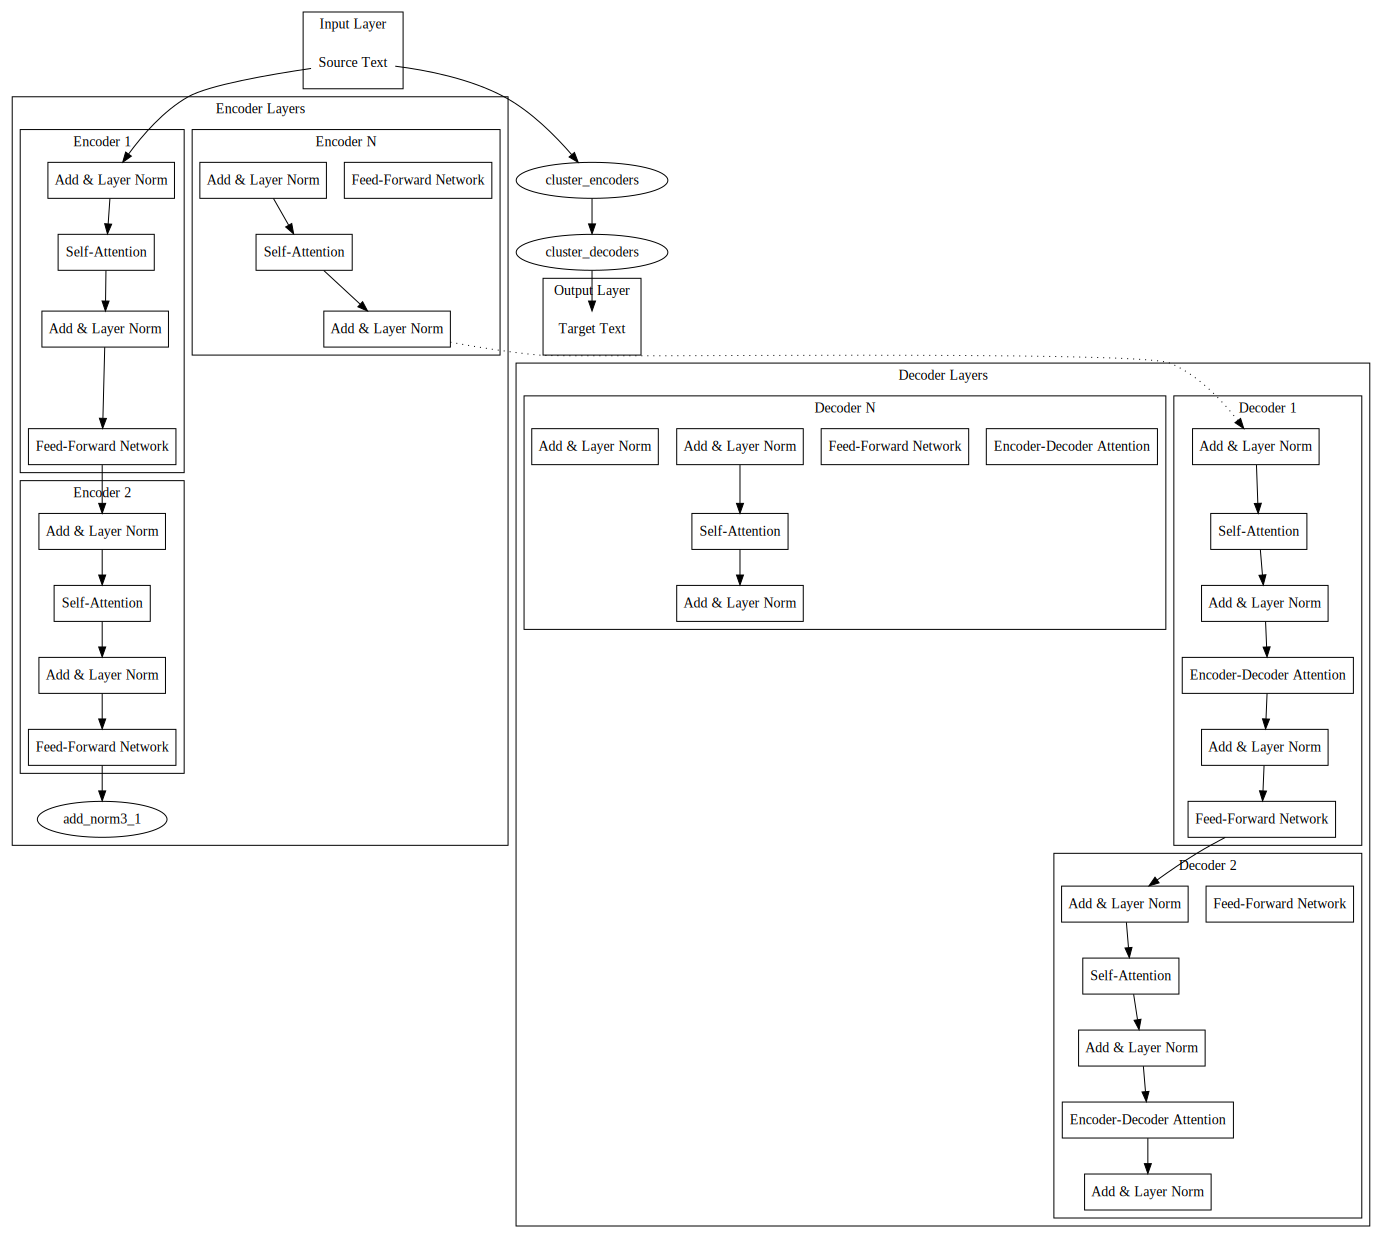

In [14]:
from IPython.display import SVG, display

# Load the SVG file and display it
svg_file = '/kaggle/input/notebook-images/marian-mt.svg'
display(SVG(filename=svg_file))

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
Importing modules </div>


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import MarianMTModel, MarianTokenizer
import numpy as np

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
The code defines a custom PyTorch dataset called `TranslationDataset` for working with machine translation data. It's functionality can be broken down into following steps:<br>
- The `__init__` method initializes the dataset by setting the paths to the input files (hypotheses_cols.tsv, hypotheses_rows.tsv, and scores.npy) and the MarianTokenizer for the specific translation model.<br>
- The `load_data` method reads the contents of the input files into the corresponding variables (`hypotheses_cols`, `hypotheses_rows`, and `scores`).<br>
- The `__len__` method returns the length of the dataset, which is the minimum length among the three lists (`hypotheses_cols`, `hypotheses_rows`, and `scores`).<br>
- The `__getitem__` method is called when an item from the dataset is requested by index (`idx`). It retrieves the corresponding source text, target text, and score. Then, it encodes the source and target texts using the tokenizer, applying padding and truncation as necessary. Finally, it returns a dictionary containing the source inputs, target inputs, and score.<br>
</div>

In [2]:
class TranslationDataset(Dataset):
    def __init__(self, dataset_path):
        self.hypotheses_cols_path = dataset_path + '/deen_nt2021_bleurt_0p2/hypotheses_cols.tsv'
        self.hypotheses_rows_path = dataset_path + '/deen_nt2021_bleurt_0p2/hypotheses_rows.tsv'
        self.scores_path = dataset_path + '/deen_nt2021_bleurt_0p2/scores.npy'
        self.tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-de-en')
        self.hypotheses_cols = []
        self.hypotheses_rows = []
        self.scores = []
        self.load_data()

    def load_data(self):
        with open(self.hypotheses_cols_path, 'r', encoding='utf-8') as f:
            self.hypotheses_cols = f.read().splitlines()
        with open(self.hypotheses_rows_path, 'r', encoding='utf-8') as f:
            self.hypotheses_rows = f.read().splitlines()
        self.scores = np.load(self.scores_path)

    def __len__(self):
        return min(len(self.hypotheses_cols), len(self.hypotheses_rows), len(self.scores))

    def __getitem__(self, idx):
        source_text = self.hypotheses_cols[idx]
        target_text = self.hypotheses_rows[idx]
        score = self.scores[idx]
        source_inputs = self.tokenizer.encode(source_text, padding='max_length', truncation=True, max_length=128,
                                              return_tensors='pt')
        target_inputs = self.tokenizer.encode(target_text, padding='max_length', truncation=True, max_length=128,
                                              return_tensors='pt')
        return {
            'source_inputs': source_inputs.squeeze(),
            'target_inputs': target_inputs.squeeze(),
            'score': score
        }


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
The `collate_fn` function is a custom collate function used for data batching in the DataLoader. It takes a list of individual data samples (batch) and combines them into a single batch tensor for efficient processing. It's functionality can be broken down into following steos:<br>
- It retrieves the 'source_inputs', 'target_inputs', and 'score' from each item in the batch using list comprehensions.<br>
- It uses `torch.stack` to stack the 'source_inputs' and 'target_inputs' tensors along a new dimension, creating a batch tensor for both inputs.<br>
- It converts the list of scores to a tensor using `torch.tensor`.<br>
- Finally, it returns a dictionary containing the batched 'source_inputs', 'target_inputs', and 'score'.<br>
</div>

In [3]:
def collate_fn(batch):
    source_inputs = torch.stack([item['source_inputs'] for item in batch])
    target_inputs = torch.stack([item['target_inputs'] for item in batch])
    scores = torch.tensor([item['score'] for item in batch])
    return {
        'source_inputs': source_inputs,
        'target_inputs': target_inputs,
        'score': scores
    }


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
In this code snippet, the dataset is initialized using the `TranslationDataset` class, which takes the `dataset_path` as an argument.<br>
After initializing the dataset, a `DataLoader` is created using the `dataset`. The `batch_size` is set to 32, which means that the DataLoader will yield batches of 32 samples at a time. The `collate_fn` is passed as an argument to the `collate_fn` parameter, which will be used to collate the samples into batches. Additionally, `shuffle=True` is set to shuffle the samples during training.
</div>

In [4]:
dataset_path = '/kaggle/input/machine-translation-mbr-with-neural-metrics/de-en/newstest2021'  # Replace with the actual path to the dataset
dataset = TranslationDataset(dataset_path)
dataloader = DataLoader(dataset, batch_size=32, collate_fn=collate_fn, shuffle=True)


/opt/conda/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
Performing sanity check of the dataloader</div>

In [5]:
for batch in dataloader:
    print(batch)
    break

{'source_inputs': tensor([[  448,   976,  1009,  ..., 58100, 58100, 58100],
        [  448,   129,  1741,  ..., 58100, 58100, 58100],
        [  448,   184,  3034,  ..., 58100, 58100, 58100],
        ...,
        [  448, 20649,  8917,  ..., 58100, 58100, 58100],
        [  448,   300,  2348,  ..., 58100, 58100, 58100],
        [  448,   184,  4484,  ..., 58100, 58100, 58100]]), 'target_inputs': tensor([[  448,   976,  1009,  ..., 58100, 58100, 58100],
        [  448,   129,  1741,  ..., 58100, 58100, 58100],
        [  448,   184,  3034,  ..., 58100, 58100, 58100],
        ...,
        [  448, 20649,  8917,  ..., 58100, 58100, 58100],
        [  448,   300,  2348,  ..., 58100, 58100, 58100],
        [  448,   184,  4484,  ..., 58100, 58100, 58100]]), 'score': tensor([[[0.9766, 0.7578, 0.7422,  ..., 0.3594, 0.2500, 0.3477],
         [0.7578, 0.9922, 0.8672,  ..., 0.3711, 0.2363, 0.3242],
         [0.7812, 0.8672, 0.9766,  ..., 0.4160, 0.2402, 0.3164],
         ...,
         [0.2305, 0.1

/tmp/ipykernel_29/1405038457.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:245.)
  scores = torch.tensor([item['score'] for item in batch])


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
In this code, the device is set based on the availability of CUDA. If CUDA is available, the device is set to `'cuda'`, otherwise it is set to `'cpu'`.<br>
The `model_name` variable is set to `'Helsinki-NLP/opus-mt-de-en'`, which is the pre-trained model name for the Marian machine translation model that translates German to English.<br>
The `MarianMTModel` is then initialized using `from_pretrained()` with the `model_name` and moved to the specified device using `.to(device)`.<br>
An optimizer is created using `torch.optim.Adam` and the parameters of the `model` are passed to it. The learning rate is set to `1e-4`.<br></div>


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'Helsinki-NLP/opus-mt-de-en'
model = MarianMTModel.from_pretrained(model_name).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
Training loop<br></div>


In [7]:
for epoch in range(1):
    for step,batch in enumerate(dataloader):
        source_inputs = batch['source_inputs'].to(device)
        target_inputs = batch['target_inputs'].to(device)
        scores = batch['score'].to(device)

        optimizer.zero_grad()
        outputs = model(source_inputs, decoder_input_ids=target_inputs, return_dict=True)
        logits = outputs.logits.flatten()
        
        # Reshape scores to match the size of logits
        scores = scores.view(-1)

        # Resize logits to match the size of scores
        logits = logits[:scores.size(0)]

        # Convert logits and scores to Float dtype
        logits = logits.float()
        scores = scores.float()

        loss = torch.nn.functional.mse_loss(logits, scores)
        loss.backward()
        optimizer.step()
        
        print("Step-{}, Loss-{}".format(step,loss.item()))


Step-0, Loss-6.140812873840332
Step-1, Loss-5.103466033935547
Step-2, Loss-33.85565185546875
Step-3, Loss-1.0194576978683472
Step-4, Loss-2.71262526512146
Step-5, Loss-2.3830552101135254
Step-6, Loss-0.8063452243804932
Step-7, Loss-0.594483494758606
Step-8, Loss-1.063205361366272
Step-9, Loss-0.8688474893569946
Step-10, Loss-0.39699050784111023
Step-11, Loss-0.2795497477054596
Step-12, Loss-0.39580032229423523
Step-13, Loss-0.5460092425346375
Step-14, Loss-0.3480374217033386
Step-15, Loss-0.23657439649105072
Step-16, Loss-0.18055318295955658
Step-17, Loss-0.25841689109802246
Step-18, Loss-0.3393004536628723
Step-19, Loss-0.2732982337474823
Step-20, Loss-0.14043833315372467
Step-21, Loss-0.11748728901147842
Step-22, Loss-0.14804702997207642
Step-23, Loss-0.19636274874210358
Step-24, Loss-0.14661014080047607
Step-25, Loss-0.07689355313777924
Step-26, Loss-0.07264295965433121
Step-27, Loss-0.0739104300737381
Step-28, Loss-0.11785602569580078
Step-29, Loss-0.10988137125968933
Step-30, Loss

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
Inference loop</div>


In [8]:
# Define the German text
german_text = "Guten Tag!"


In [9]:
# Load the tokenizer
model_name = 'Helsinki-NLP/opus-mt-de-en'

tokenizer = MarianTokenizer.from_pretrained(model_name)


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
In the code snippet provided, the German text stored in the variable `german_text` is tokenized using the `tokenizer.encode()` method.<br>
The `return_tensors='pt'` parameter specifies that the encoded tokens should be returned as PyTorch tensors. The resulting tokenized representation of the German text is stored in the variable `inputs`.<br></div>

In [10]:
# Tokenize the German text
inputs = tokenizer.encode(german_text, return_tensors='pt')


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
In the code snippet, the tokenized German text stored in the variable `inputs` is passed to the `model.generate()` method to perform inference. <br>
The `generate()` method is used for sequence generation and takes the tokenized input as input. It generates the corresponding translated output sequence using the pre-trained translation model. <br>
The resulting translated output sequence is stored in the variable `outputs`.<br></div>

In [11]:
# Perform inference
outputs = model.generate(inputs.to(model.device))


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
The translated output sequence stored in the variable `outputs` is decoded using the `tokenizer.decode()` method. The `decode()` method takes the tensor of token IDs (`outputs[0]`) and converts it back to text.<br>
The `skip_special_tokens=True` argument is used to exclude any special tokens, such as padding or end-of-sequence tokens, from the decoded text. This ensures that only the meaningful translated text is extracted.<br>
The resulting English translation is stored in the variable `english_translation`.<br></div>

In [12]:
# Decode the English translation
english_translation = tokenizer.decode(outputs[0], skip_special_tokens=True)


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
Displaying the translation output</div>

In [13]:
# Print the translated text
print("German Text: ", german_text)
print("English Translation: ", english_translation)


German Text:  Guten Tag!
English Translation:  Hello!
